In [1]:
#omport Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#Load sales, products, and category dataset
sales = pd.read_csv( "data_set\sales.csv")
products = pd.read_csv("data_set\products.csv")
categories = pd.read_csv("data_set\categories.csv")

In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6758125 entries, 0 to 6758124
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   SalesID            int64  
 1   SalesPersonID      int64  
 2   CustomerID         int64  
 3   ProductID          int64  
 4   Quantity           int64  
 5   Discount           float64
 6   TotalPrice         float64
 7   SalesDate          object 
 8   TransactionNumber  object 
dtypes: float64(2), int64(5), object(2)
memory usage: 464.0+ MB


In [4]:
sales.head()

,SalesID,SalesPersonID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber
0,1,6,27039,381,7,0.0,0.0,2018-02-05 07:38:25.430,FQL4S94E4ME1EZFTG42G
1,2,16,25011,61,7,0.0,0.0,2018-02-02 16:03:31.150,12UGLX40DJ1A5DTFBHB8
2,3,13,94024,23,24,0.0,0.0,2018-05-03 19:31:56.880,5DT8RCPL87KI5EORO7B0
3,4,8,73966,176,19,0.2,0.0,2018-04-07 14:43:55.420,R3DR9MLD5NR76VO17ULE
4,5,10,32653,310,9,0.0,0.0,2018-02-12 15:37:03.940,4BGS0Z5OMAZ8NDAFHHP3


In [5]:
#Data cleaning & restructuring


#Convert SalesDate column to datetime format
#errors="coerce" converts invalid dates to NaT
sales["SalesDate"] = pd.to_datetime(sales["SalesDate"], errors="coerce")

#Remove rows where SalesDate is missing
sales = sales.dropna(subset=["SalesDate"])
#Keep only the date part (remove time)
sales["SalesDate"] = sales["SalesDate"].dt.date

In [6]:
sales.head(10)

,SalesID,SalesPersonID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber
0,1,6,27039,381,7,0.0,0.0,2018-02-05,FQL4S94E4ME1EZFTG42G
1,2,16,25011,61,7,0.0,0.0,2018-02-02,12UGLX40DJ1A5DTFBHB8
2,3,13,94024,23,24,0.0,0.0,2018-05-03,5DT8RCPL87KI5EORO7B0
3,4,8,73966,176,19,0.2,0.0,2018-04-07,R3DR9MLD5NR76VO17ULE
4,5,10,32653,310,9,0.0,0.0,2018-02-12,4BGS0Z5OMAZ8NDAFHHP3
5,6,13,28663,413,8,0.0,0.0,2018-02-07,3KTAYIZPGDQMZMRWZ8NG
6,7,14,46674,370,12,0.0,0.0,2018-03-02,ICRZIHELQCVB71RNH1G5
7,8,3,12687,287,4,0.2,0.0,2018-01-17,6X9MOQIJH92NIK81BG0K
8,9,16,89009,124,23,0.0,0.0,2018-04-27,P0UARL09H66APBEIDUQW
9,10,22,65017,346,17,0.2,0.0,2018-03-26,92TNPGIL6LFKVGWFBW5H


In [7]:
#Dictionary defining manual product-to-category rules
#This to ensures consistent categorization when categories are not fitted or unclear
category_rules = {
    "Seafood": [
        "Halibut - Steaks",
        "Scampi Tail",
        "Squid - Tubes / Tenticles 10/20",
        "Shrimp - 31/40",
        "Pickerel - Fillets",
        "Anchovy Paste - 56 G Tube",
        "Sole - Dover, Whole, Fresh",
        "Clam Nectar",
        "Halibut - Fletches",
        "Tuna - Salad Premix",
        "Cod - Black Whole Fillet",
        "Scallops - Live In Shell",
        "Salmon - Atlantic, Skin On",
        "Barramundi",
        "Crab - Dungeness, Whole",
        "Crab - Imitation Flakes",
        "Fish - Scallops, Cold Smoked",
        "Grouper - Fresh",
        "Mussels - Cultivated",
        "Mussels - Frozen",
        "Salmon - Sockeye Raw",
        "Sardines",
        "Scallops - 10/20",
        "Scallops 60/80 IQF",
        "Shrimp - Baby, Warm Water",
        "Squid U5 - Thailand"
    ],
    "Meat": [
        "Beef - Top Sirloin",
        "Beef - Ground Medium",
        "Pork - Kidney",
        "Chicken - Soup Base",
        "Sausage - Breakfast",
        "Beef - Ground, Extra Lean, Fresh",
        "Veal - Inside",
        "Pork - Bacon, Double Smoked",
        "Turkey - Whole, Fresh",
        "Veal - Brisket, Provimi,bnls",
        "Veal - Eye Of Round",
        "Pork - Loin, Center Cut",
        "Veal - Sweetbread",
        "Beef - Tenderlion, Center Cut",
        "Lamb - Pieces, Diced",
        "Pork - Belly Fresh",
        "Beef - Short Loin",
        "Beef - Chuck, Boneless",
        "Beef - Inside Round",
        "Beef - Montreal Smoked Brisket",
        "Beef - Prime Rib Aaa",
        "Beef - Rib Eye AAA",
        "Beef - Striploin AA",
        "Beef - Texas Style Burger",
        "Beef - Top Sirloin - AAA",
        "Beef Wellington",
        "Chicken - Leg, Boneless",
        "Chicken - Wieners",
        "Duck - Breast",
        "Guinea Fowl",
        "Lamb - Ground",
        "Lamb - Whole, Fresh",
        "Pork - Back, Short Cut, Boneless",
        "Pork - Hock And Feet Attached",
        "Pork - Inside",
        "Pork - Loin, Bone-In",
        "Sausage - Liver",
        "Turkey - Oven Roast Breast",
        "Veal - Inside, Choice",
        "Veal - Osso Bucco",
        "Veal - Slab Bacon"
    ],
    "Dairy": [
        "Cheese - Brie, Triple Creme",
        "Cheese - Wine",
        "Cheese - Parmesan Cubes",
        "Cheese - Bocconcini",
        "Cheese - Mozzarella",
        "Milk - 2%",
        "Yoghurt Tubes",
        "Cheese - Brie,danish",
        "Cheese - Taleggio D.o.p.",
        "Yogurt - Blueberry, 175 Gr",
        "Cheese - Mix",
        "Cocoa Butter",
        "Cheese - Cottage Cheese",
        "Butter - Unsalted",
        "Cheese - Boursin, Garlic / Herbs",
        "Cheese - Cambozola",
        "Cheese - Camembert",
        "Milk Powder",
        "Yogurt - French Vanilla"
    ],
    "Beverages": [
        "Tea - Earl Grey",
        "Water - Mineral, Natural",
        "Brandy - Bar",
        "Carbonated Water - Cherry",
        "Jolt Cola - Electric Blue",
        "Tia Maria",
        "Ocean Spray - Kiwi Strawberry",
        "Rum - Coconut, Malibu",
        "Arizona - Green Tea",
        "Sherry - Dry",
        "Smirnoff Green Apple Twist",
        "Crush - Cream Soda",
        "Nantucket - Pomegranate Pear",
        "Juice - V8 Splash",
        "Snapple - Iced Tea Peach",
        "Pop Shoppe Cream Soda",
        "Tea - Decaf Lipton",
        "Water - Green Tea Refresher",
        "Jagermeister",
        "Rum - Mount Gay Eclipes",
        "Tea - Jasmin Green",
        "Pepsi - Diet, 355 Ml",
        "Gatorade - Xfactor Berry",
        "Nantuket Peach Orange",
        "Coffee - Dark Roast",
        "Coffee - Hazelnut Cream",
        "Coffee - Irish Cream",
        "Coffee Decaf Colombian",
        "Hot Chocolate - Individual",
        "Juice - Apple Cider",
        "Juice - Cranberry, 341 Ml",
        "Juice - Happy Planet",
        "Juice - Lime",
        "Juice - Orange",
        "Lemonade - Natural",
        "Ocean Spray - Ruby Red",
        "Tea - English Breakfast",
        "Tea - Herbal Sweet Dreams",
        "Water - Aquafina Vitamin",
        "Water - Spring Water 500ml",
        "Water, Tap"
    ],
    "Beer": [
        "Beer - Alexander Kieths, Pale Ale",
        "Beer - Blue",
        "Beer - Labatt Blue",
        "Beer - Original Organic Lager",
        "Beer - Rickards Red",
        "Beer - Sleemans Cream Ale"
    ],
    "Wine": [
        "Wine - White, Colubia Cresh",
        "Wine - Sogrape Mateus Rose",
        "Wine - Fume Blanc Fetzer",
        "Wine - Magnotta - Belpaese",
        "Wine - Pinot Noir Latour",
        "Wine - Magnotta, Merlot Sr Vqa",
        "Wine - Chardonnay Errazuriz",
        "Wine - Chablis 2003 Champs",
        "Wine - Valpolicella Masi",
        "Wine - Gato Negro Cabernet",
        "Wine - Red, Harrow Estates, Cab",
        "Wine - Two Oceans Cabernet",
        "Wine - White Cab Sauv.on",
        "Wine - Redchard Merritt",
        "Wine - Vineland Estate Semi - Dry",
        "Wine - Ruffino Chianti",
        "Wine - Ej Gallo Sierra Valley",
        "Wine - Vidal Icewine Magnotta",
        "Wine - Alsace Gewurztraminer",
        "Wine - Blue Nun Qualitatswein",
        "Wine - Cahors Ac 2000, Clos",
        "Wine - Chardonnay South",
        "Wine - Crozes Hermitage E.",
        "Wine - Hardys Bankside Shiraz",
        "Wine - Magnotta - Cab Sauv",
        "Wine - Prosecco Valdobiaddene",
        "Wine - Red, Colio Cabernet",
        "Wine - Red, Cooking",
        "Wine - Toasted Head",
        "Wine - White, Mosel Gold",
        "Wine - White, Schroder And Schyl",
        "Wine - Wyndham Estate Bin 777"
    ],
    "Grain": [
        "Flour - Whole Wheat",
        "Rice - Jasmine Sented",
        "Oil - Shortening - All - Purpose",
        "Lentils - Red, Dry",
        "Soup - Campbells, Lentil",
        "Coconut - Shredded, Sweet",
        "Wanton Wrap",
        "Bagel - Plain",
        "Onion Powder",
        "Soup Knorr Chili With Beans",
        "Beans - Kidney, Canned",
        "Sugar - Fine",
        "Flour - Teff",
        "Sunflower Seed Raw",
        "Beans - Kidney, Red Dry"
    ],
    "Bread & Bakery": [
        "Bread Crumbs - Japanese Style",
        "Bread - Roll, Soft White Round",
        "Bread Crumbs - Panko",
        "Bread - English Muffin",
        "Bread Fig And Almond",
        "Bread - Italian Roll With Herbs",
        "Bread - Rye",
        "Bread - Calabrese Baguette",
        "Bread - Italian Corn Meal Poly"
    ],
    "Cereals": [
        "Kellogs All Bran Bars",
        "Cookies Cereal Nut",
        "Pecan Raisin - Tarts",
        "Cinnamon Buns Sticky",
        "Macaroons - Two Bite Choc",
        "Crackers - Trio",
        "Bar - Granola Trail Mix Fruit Nut",
        "Cookie Chocolate Chip With",
        "Crackers Cheez It",
        "Muffin - Carrot Individual Wrap",
        "Cookie - Dough Variety"
    ],
    "Desserts & Baking Ingredients": [
        "Chocolate - Feathers",
        "Chocolate - Dark",
        "Assorted Desserts",
        "Quiche Assorted",
        "Puree - Mocha",
        "Tahini Paste",
        "Ice Cream Bar - Drumstick",
        "Dc - Frozen Momji",
        "Ice Cream Bar - Oreo Cone",
        "Baking Powder"
    ],
    "Produce": [
        "Kiwi",
        "Spinach - Baby",
        "Pie Filling - Cherry",
        "Beets - Candy Cane, Organic",
        "Bananas",
        "Lettuce - Treviso",
        "Mushrooms - Black, Dried",
        "Apricots Fresh",
        "Eggplant - Asian",
        "Tomatoes Tear Drop",
        "Lettuce - Frisee",
        "Garlic - Peeled",
        "Mushroom - Trumpet, Dry",
        "Garlic",
        "Banana - Leaves",
        "Sun - Dried Tomatoes",
        "Oranges - Navel, 72",
        "Fuji Apples",
        "Olives - Stuffed",
        "Rambutan",
        "Pomello",
        "Seedlings - Mix, Organic",
        "Puree - Passion Fruit",
        "Blueberries",
        "Durian Fruit",
        "Berry Brulee",
        "Lettuce - California Mix",
        "Sauerkraut",
        "Blackberries",
        "Bay Leaf",
        "Mangoes",
        "Papayas",
        "Pears - Bosc",
        "Potatoes - Idaho 100 Count"
    ],
    "Condiments": [
        "Mustard Prepared",
        "Vinegar - Sherry",
        "Cream Of Tartar",
        "Sauce - Hollandaise"
    ],
    "Nuts & Seeds": [
        "Nut - Pistachio, Shelled",
        "Coconut - Shredded, Sweet"
    ],
    "Herbs & Spices": [
        "Sage - Ground",
        "Rosemary - Primerba, Paste",
        "Spice - Peppercorn Melange",
        "Pepper - Black, Whole",
        "Pepper - White, Ground",
        "Bouq All Italian - Primerba",
        "Cumin - Whole",
        "Fenngreek Seed",
        "Garlic - Primerba, Paste",
        "Vinegar - Tarragon"
    ]
}



In [8]:
#Create an empty dictionary to map each product to its category
product_to_category = {}
#Loop through category rules and assign category to each product
for category, product_list in category_rules.items():
    for product in product_list:
        product_to_category[product] = category


In [9]:
#Map product names to category names
products["CategoryName"] = products["ProductName"].map(product_to_category)
#Assign "Other" to products not found in mapping
products["CategoryName"] = products["CategoryName"].fillna("Other")



In [10]:
#Manually define numeric IDs for each category
category_id_map = {
    "Cereals": 3,
    "Dairy": 4,
    "Beverages": 5,
    "Seafood": 6,
    "Meat": 7,
    "Grain": 8,
    "Desserts & Baking Ingredients": 9,
    "Produce": 10,
    "Condiments": 11,
    "Nuts & Seeds": 12,
    "Herbs & Spices": 13,
    "Beer": 14,
    "Wine": 15,
    "Bread & Bakery": 16,
    "Other": 99
}
#Map CategoryName to CategoryID
products["CategoryID"] = products["CategoryName"].map(category_id_map)


In [11]:
#Count number of products per category
category_counts = (
    products
    .groupby("CategoryName")
    .size()
    .reset_index(name="Product_Count")
    .sort_values("Product_Count", ascending=False)
)

category_counts


,CategoryName,Product_Count
11,Other,200
1,Beverages,40
9,Meat,37
12,Produce,34
14,Wine,31
13,Seafood,25
5,Dairy,19
7,Grain,14
3,Cereals,11
8,Herbs & Spices,10


In [12]:
#Merge sales data with product details
sales_products = sales.merge(
    products[
        [
            "ProductID",
            "ProductName",
            "CategoryName",
            "CategoryID",
            "Class",
            "VitalityDays",
            "Price"
            
        ]
    ],
    on="ProductID",
    how="left"
)


In [13]:
sales_products.head()

,SalesID,SalesPersonID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber,ProductName,CategoryName,CategoryID,Class,VitalityDays,Price
0,1,6,27039,381,7,0.0,0.0,2018-02-05,FQL4S94E4ME1EZFTG42G,Vaccum Bag 10x13,Other,99,High,41.0,44.2337
1,2,16,25011,61,7,0.0,0.0,2018-02-02,12UGLX40DJ1A5DTFBHB8,Sardines,Seafood,6,Low,90.0,62.5460
2,3,13,94024,23,24,0.0,0.0,2018-05-03,5DT8RCPL87KI5EORO7B0,Crab - Imitation Flakes,Seafood,6,Medium,0.0,79.0184
3,4,8,73966,176,19,0.2,0.0,2018-04-07,R3DR9MLD5NR76VO17ULE,Smirnoff Green Apple Twist,Beverages,5,High,90.0,81.3167
4,5,10,32653,310,9,0.0,0.0,2018-02-12,4BGS0Z5OMAZ8NDAFHHP3,Coffee - Dark Roast,Beverages,5,Low,0.0,79.9780


In [14]:
# Replace missing discount values with 0
sales_products["Discount"] = sales_products["Discount"].fillna(0)
# Calculate daily sales value after discount
sales_products["Sales_Value"] = (
    sales_products["Quantity"]
    * sales_products["Price"]
    * (1 - sales_products["Discount"])
)
sales_products.head()

,SalesID,SalesPersonID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber,ProductName,CategoryName,CategoryID,Class,VitalityDays,Price,Sales_Value
0,1,6,27039,381,7,0.0,0.0,2018-02-05,FQL4S94E4ME1EZFTG42G,Vaccum Bag 10x13,Other,99,High,41.0,44.2337,309.63590
1,2,16,25011,61,7,0.0,0.0,2018-02-02,12UGLX40DJ1A5DTFBHB8,Sardines,Seafood,6,Low,90.0,62.5460,437.82200
2,3,13,94024,23,24,0.0,0.0,2018-05-03,5DT8RCPL87KI5EORO7B0,Crab - Imitation Flakes,Seafood,6,Medium,0.0,79.0184,1896.44160
3,4,8,73966,176,19,0.2,0.0,2018-04-07,R3DR9MLD5NR76VO17ULE,Smirnoff Green Apple Twist,Beverages,5,High,90.0,81.3167,1236.01384
4,5,10,32653,310,9,0.0,0.0,2018-02-12,4BGS0Z5OMAZ8NDAFHHP3,Coffee - Dark Roast,Beverages,5,Low,0.0,79.9780,719.80200


In [15]:
#Aggregate daily demand and sales per product
daily_sales = (
    sales_products
    .groupby(
        ["ProductID", "ProductName", "CategoryID", "CategoryName", "SalesDate"],
        as_index=False
    )
    .agg(
        Daily_Demand=("Quantity", "sum"),
        Avg_Discount=("Discount", "mean"),
        Total_Daily_Sales=("Sales_Value", "sum")
    )
)


In [16]:
#Select relevant categories for forecasting
selected_categories = [
    "Cereals",
    "Dairy",
    "Beverages",
    "Seafood",
    "Meat",
    "Desserts & Baking Ingredients",
    "Produce",
    "Condiments",
    "Nuts & Seeds",
    "Herbs & Spices",
    "Wine",
    "Beer",
    "Bread & Bakery",
    "Grain"
]

daily_sales = daily_sales[
    daily_sales["CategoryName"].isin(selected_categories)
]

#Sort data chronologically
daily_sales = daily_sales.sort_values(
    ["ProductID", "SalesDate"]
)

In [17]:
# Select final columns for modeling
final_master_data_daily = daily_sales[
    [
        "ProductID",
        "ProductName",
        "CategoryName",
        "CategoryID",
        "SalesDate",
        "Daily_Demand",
        "Total_Daily_Sales",
        "Avg_Discount"
    ]
]

final_master_data_daily.head(100)
final_master_data_daily.info()


<class 'pandas.core.frame.DataFrame'>
Index: 32508 entries, 0 to 58049
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ProductID          32508 non-null  int64  
 1   ProductName        32508 non-null  object 
 2   CategoryName       32508 non-null  object 
 3   CategoryID         32508 non-null  int64  
 4   SalesDate          32508 non-null  object 
 5   Daily_Demand       32508 non-null  int64  
 6   Total_Daily_Sales  32508 non-null  float64
 7   Avg_Discount       32508 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 2.2+ MB


In [18]:
#EDA and trend understanding

# Aggregate daily demand at category level
category_daily = (
    final_master_data_daily
    .groupby(["CategoryName", "SalesDate"], as_index=False)
    .agg(Total_Demand=("Daily_Demand", "sum"))
)

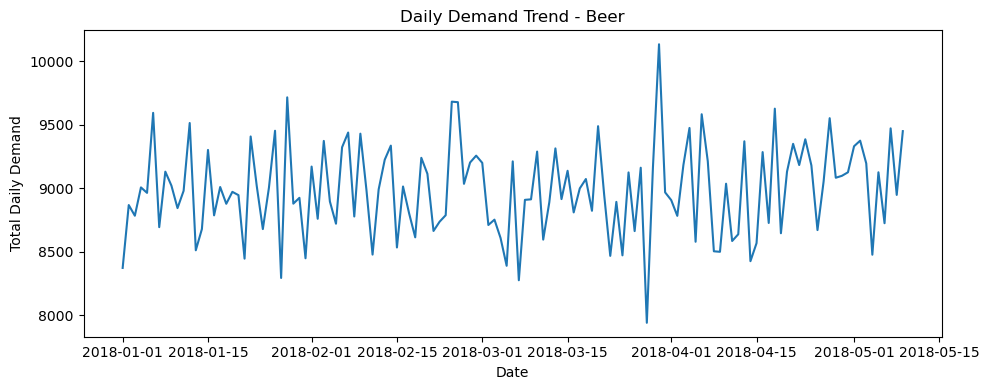

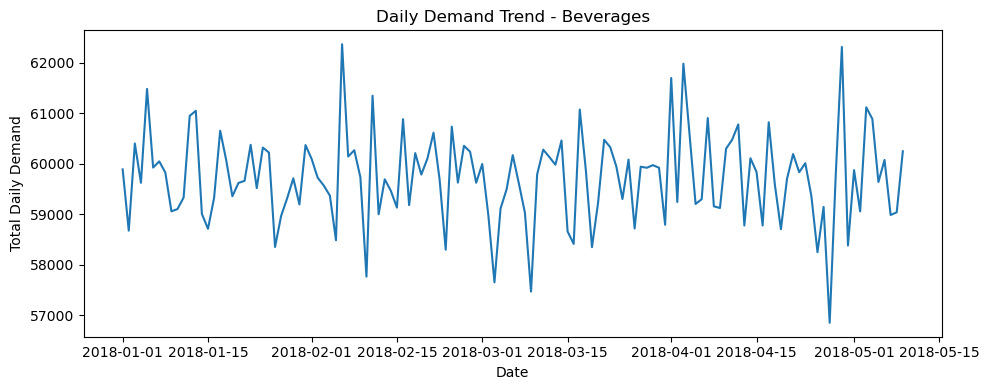

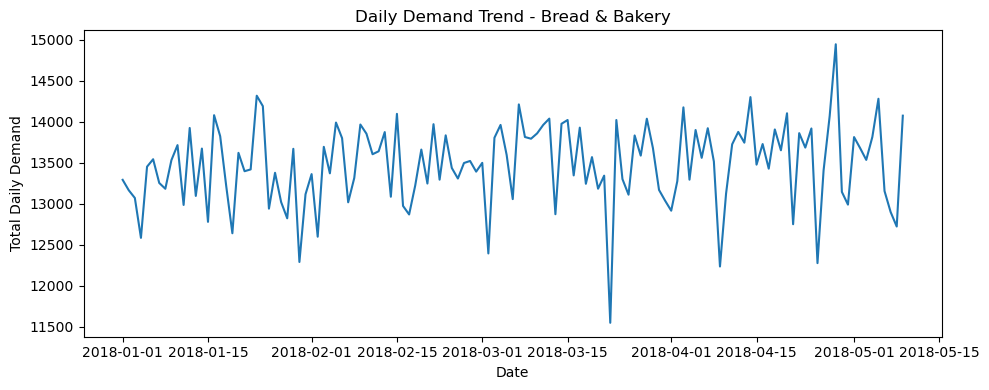

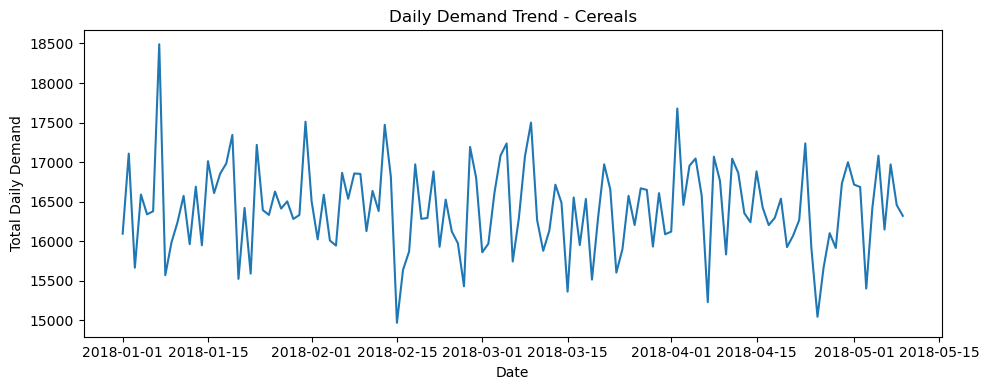

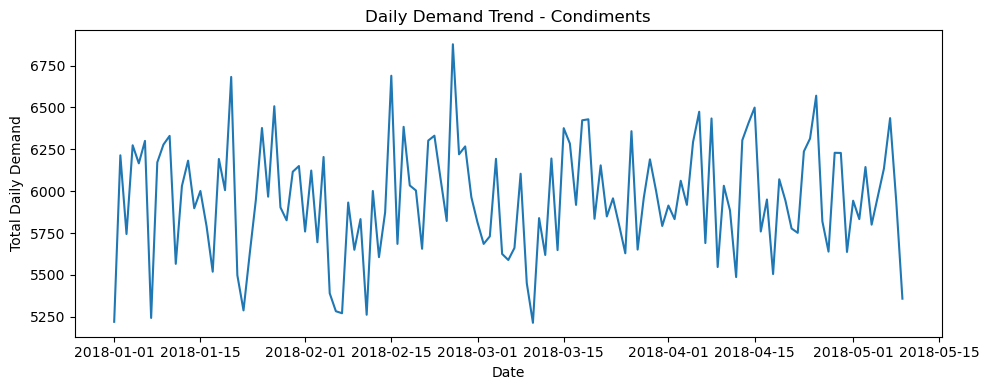

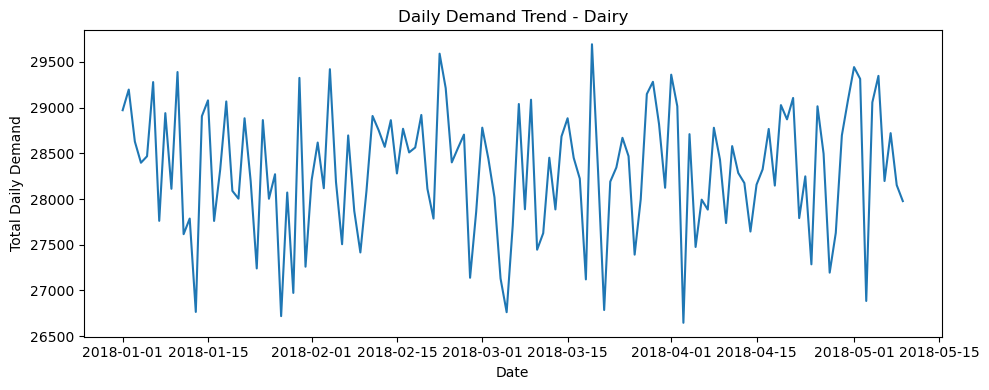

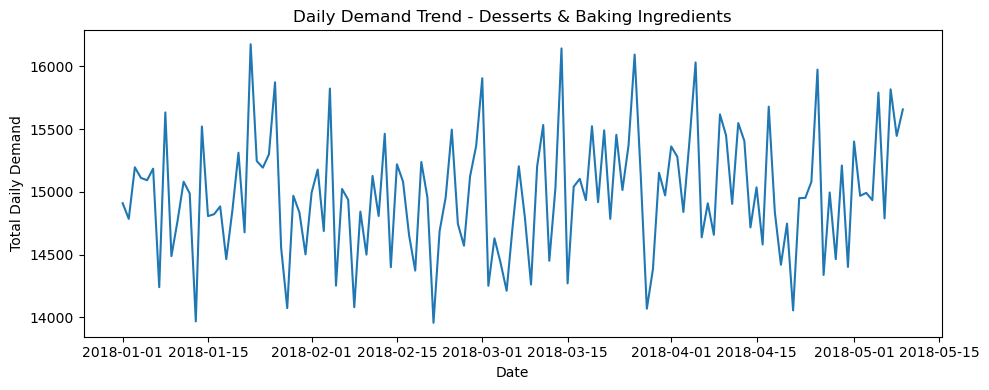

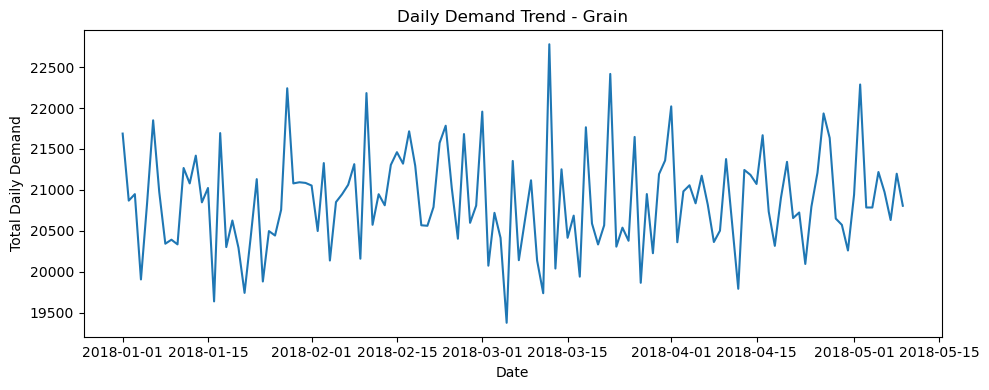

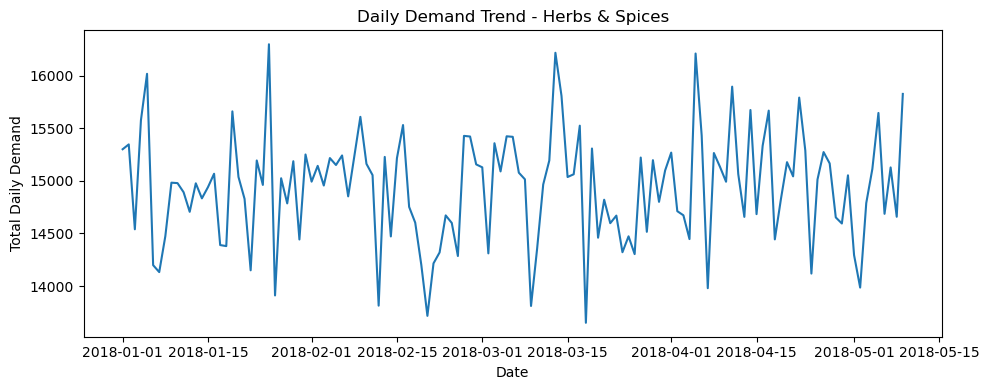

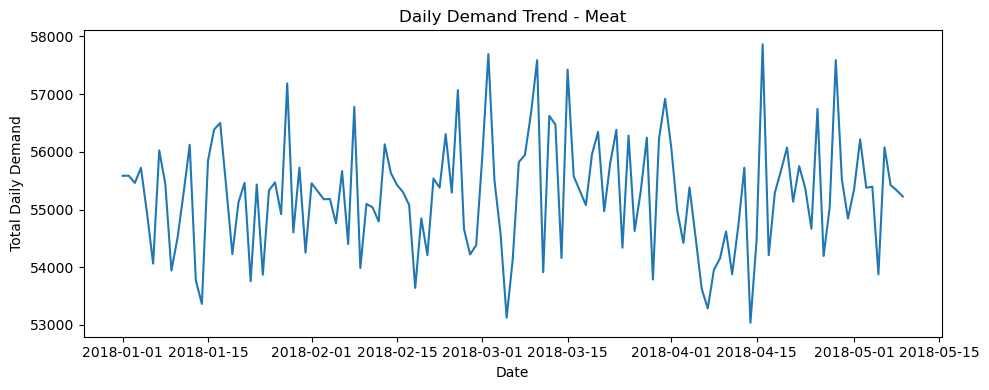

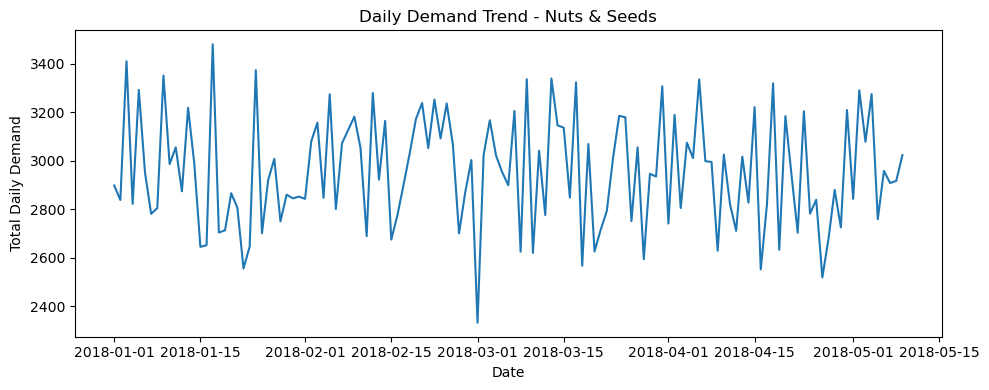

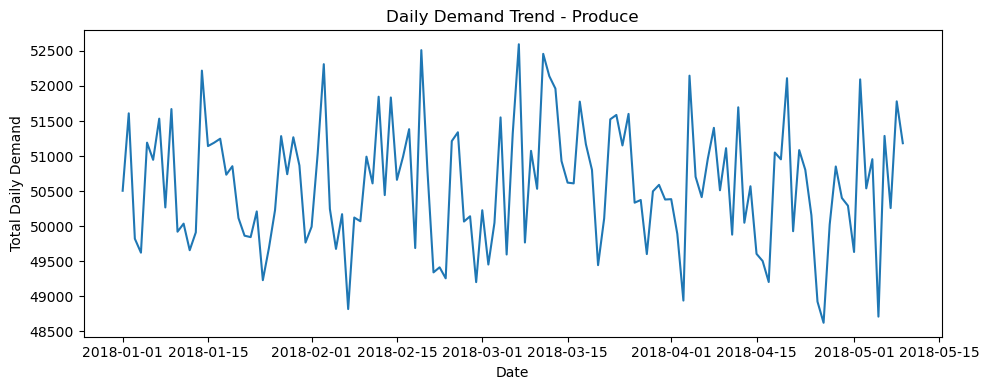

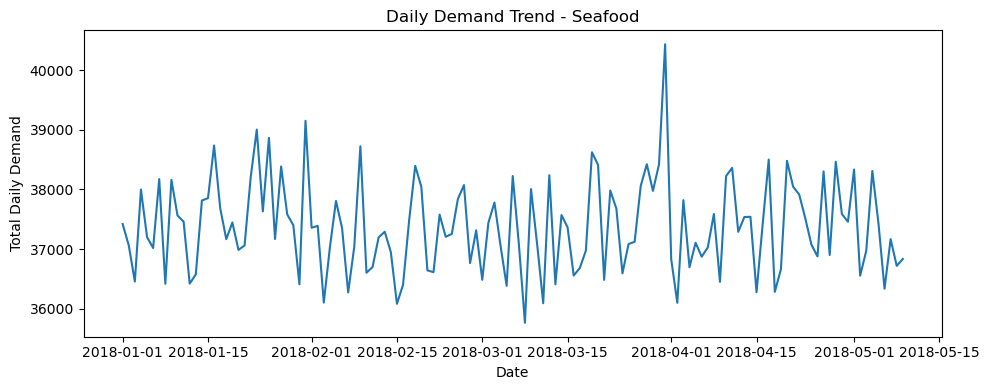

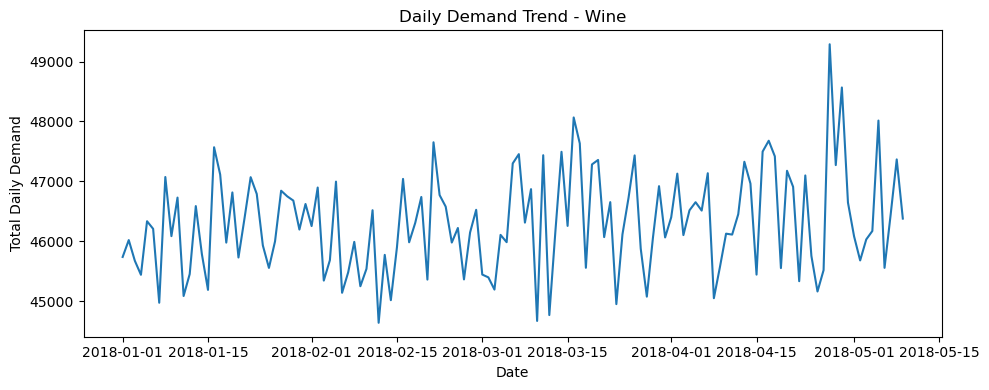

In [19]:


# Extract unique category names from the aggregated category-level dataset
# Each category will be plotted separately
categories = category_daily["CategoryName"].unique()

# Loop through each category to create individual demand trend plots
for cat in categories:
    
    # Filter the dataset for the current category
    df_cat = category_daily[
        category_daily["CategoryName"] == cat
    ]

    # Create a new figure for the category
    plt.figure(figsize=(10, 4))
    
    # Plot total daily demand over time for the category
    plt.plot(
        df_cat["SalesDate"],
        df_cat["Total_Demand"]
    )

    plt.title(f"Daily Demand Trend - {cat}")
    plt.xlabel("Date")
    plt.ylabel("Total Daily Demand")
    plt.tight_layout()
    plt.show()

In [20]:
#Select one representative product per category
selected_products = {
    "Cereals": "Cookie Chocolate Chip With",
    "Dairy": "Milk - 2%",
    "Beverages": "Tea - Earl Grey",
    "Meat": "Beef - Ground Medium",
    "Seafood": "Shrimp - 31/40",
    "Wine": "Wine - Redchard Merritt",
    "Grain": "Sugar - Fine",
    "Bread & Bakery": "Bread - Italian Roll With Herbs",
    "Cereals": "Kellogs All Bran Bars",
    "Desserts & Baking Ingredients": "Baking Powder",
    "Produce": "Bananas",
    "Condiments": "Mustard Prepared",
    "Nuts & Seeds": "Nut - Pistachio, Shelled",
    "Herbs & Spices": "Rosemary - Primerba, Paste",
        
    
}


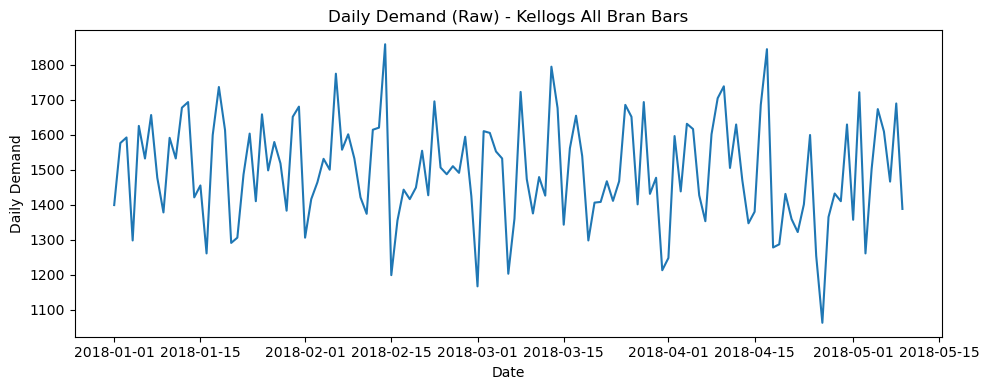

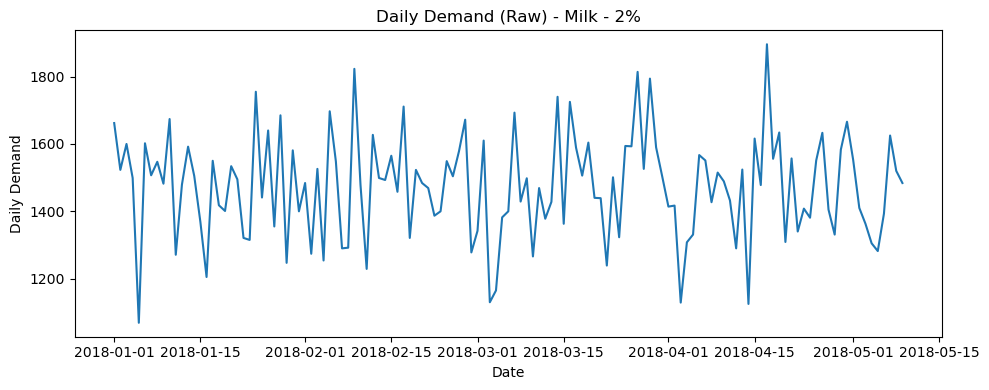

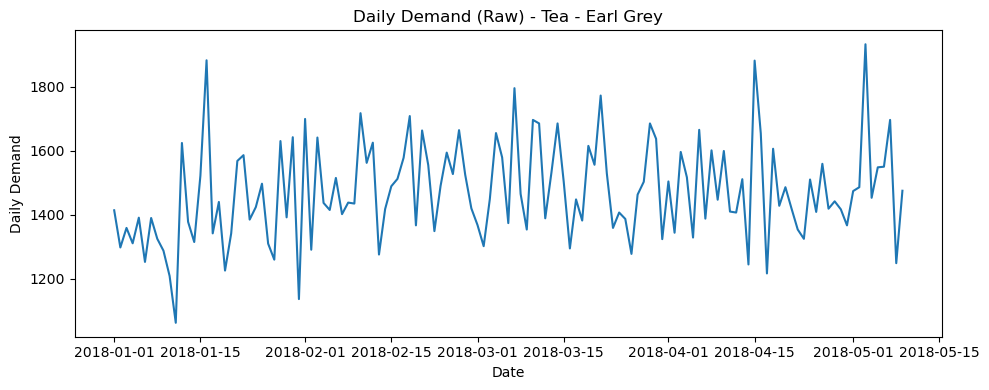

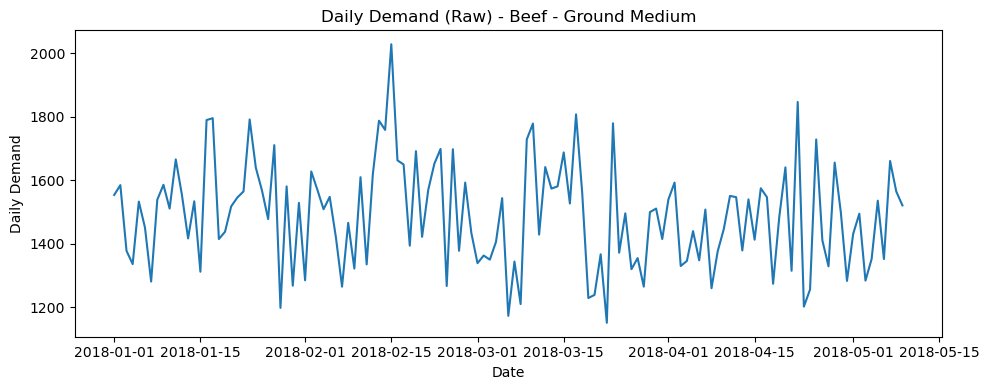

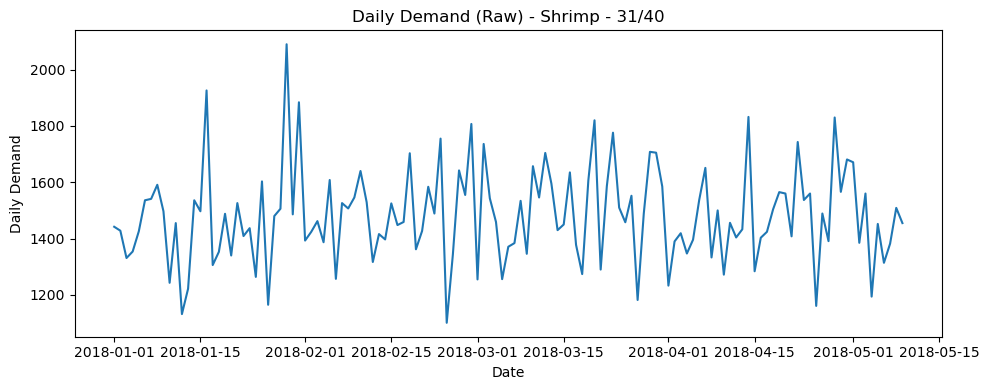

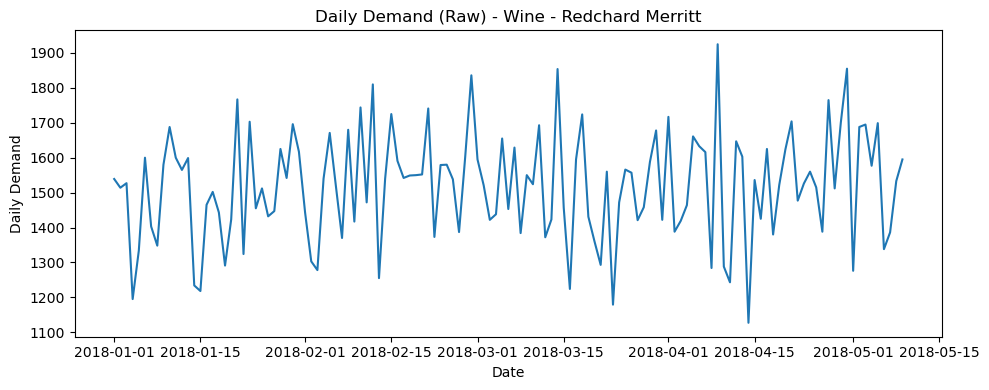

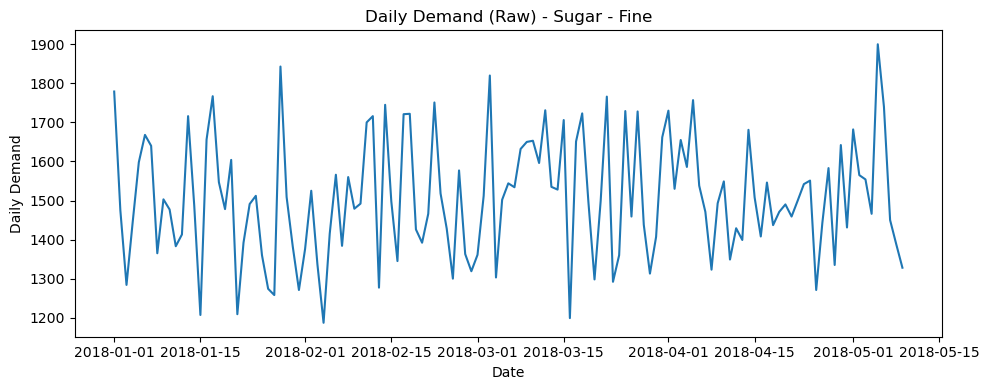

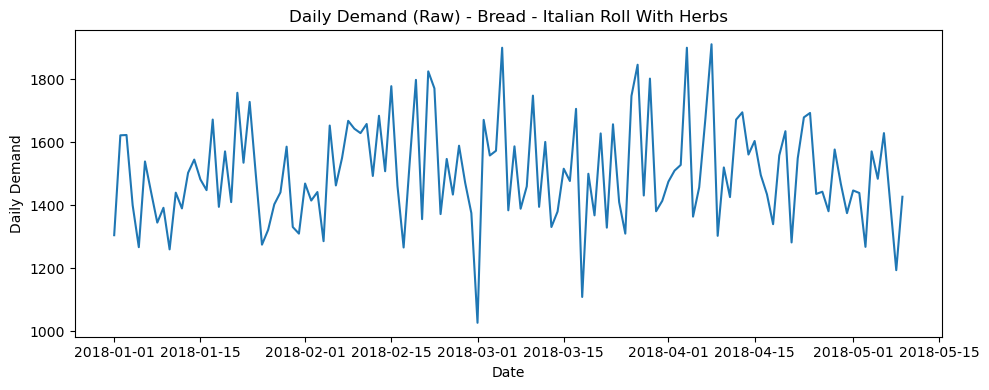

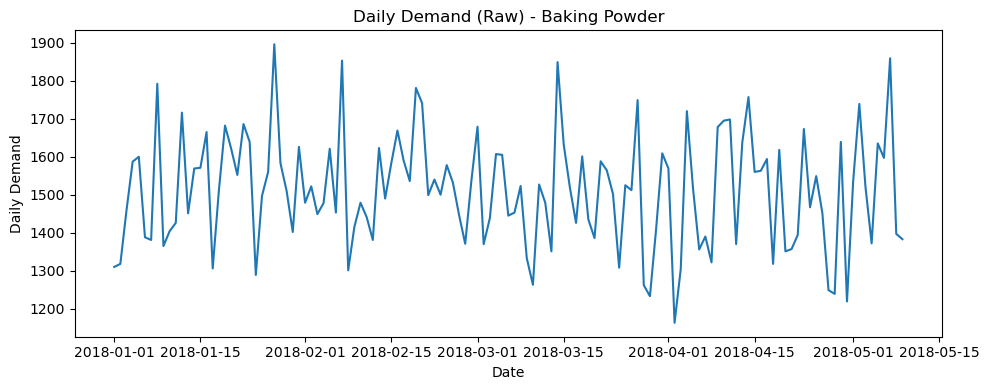

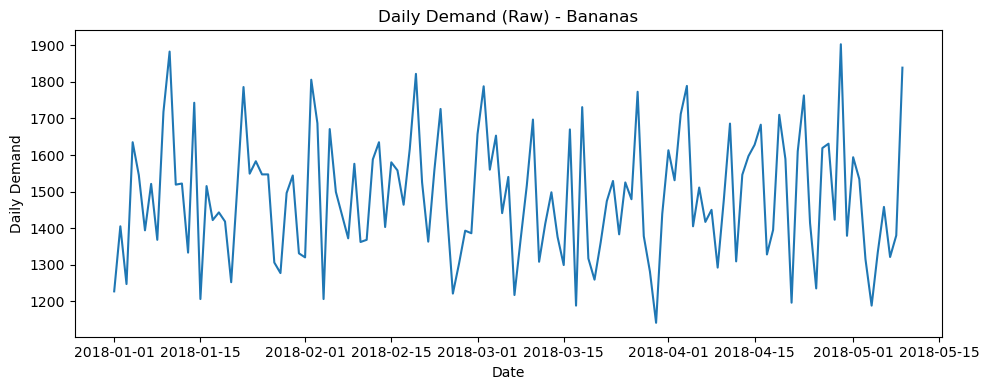

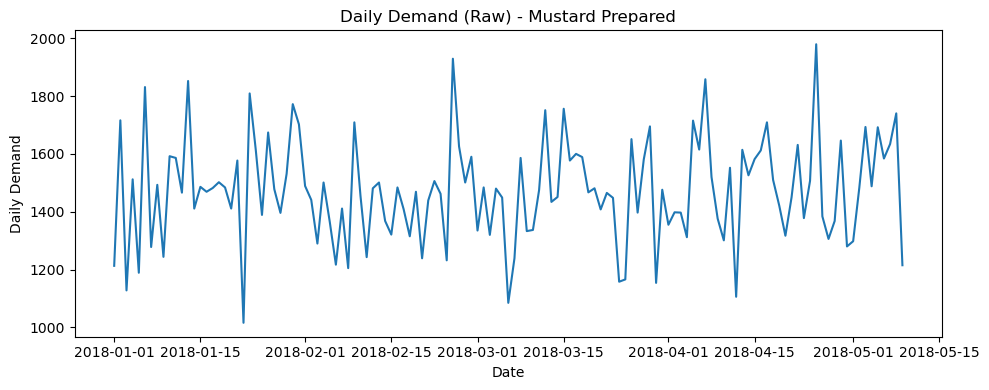

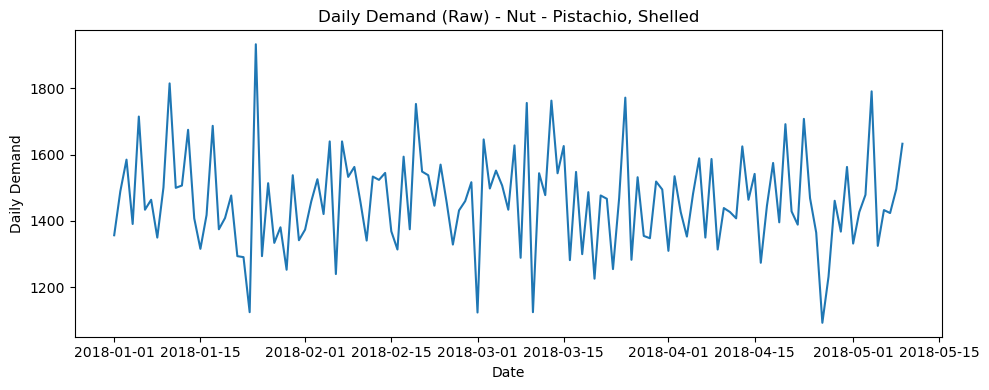

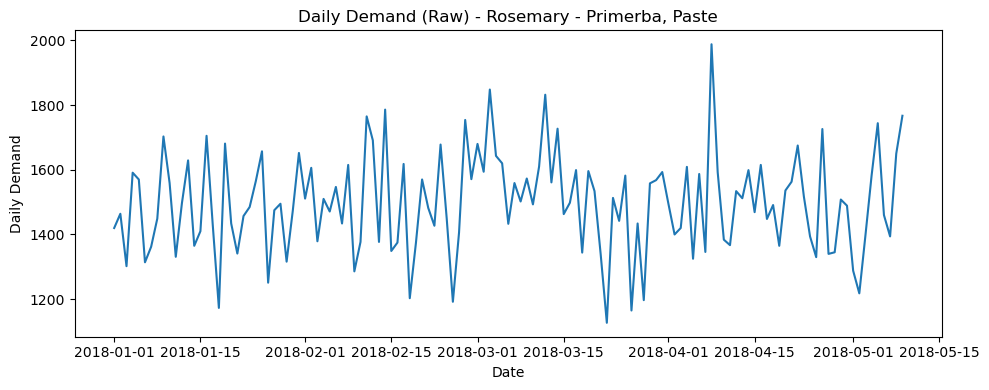

In [21]:

# Loop through each (category, product) pair selected for detailed analysis
for category, product in selected_products.items():

    # Filter the master daily dataset for the specific product
    # and sort records chronologically by date
    df_prod = final_master_data_daily[
        final_master_data_daily["ProductName"] == product
    ].sort_values("SalesDate")

    # Create a new figure for the product's demand time series
    plt.figure(figsize=(10, 4))

    # Plot the raw (unsmoothed) daily demand values over time
    plt.plot(
        df_prod["SalesDate"],
        df_prod["Daily_Demand"]
    )

    plt.title(f"Daily Demand (Raw) - {product}")
    plt.xlabel("Date")
    plt.ylabel("Daily Demand")
    plt.tight_layout()
    plt.show()


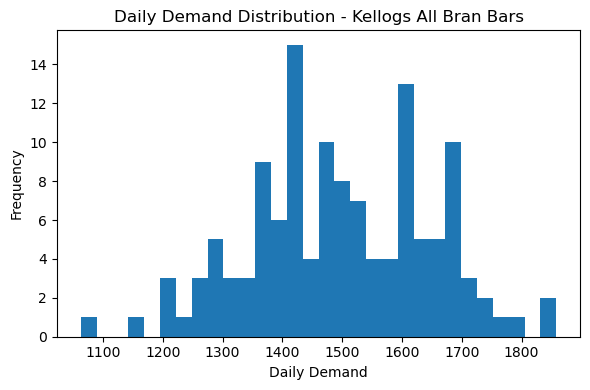

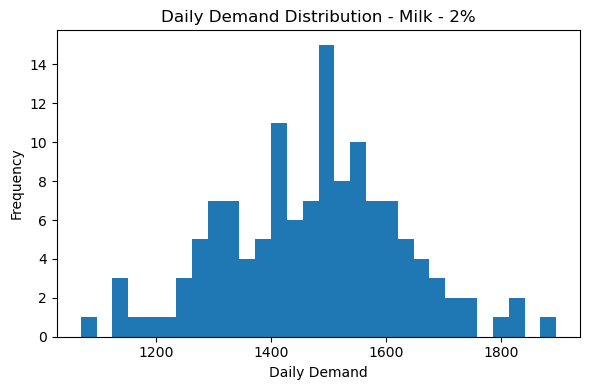

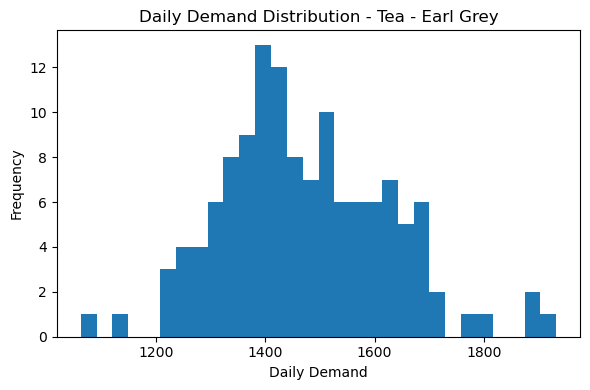

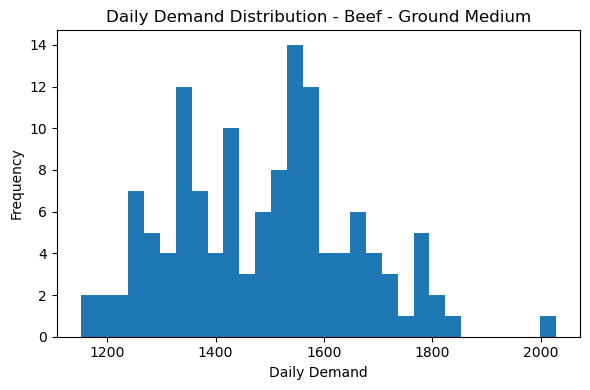

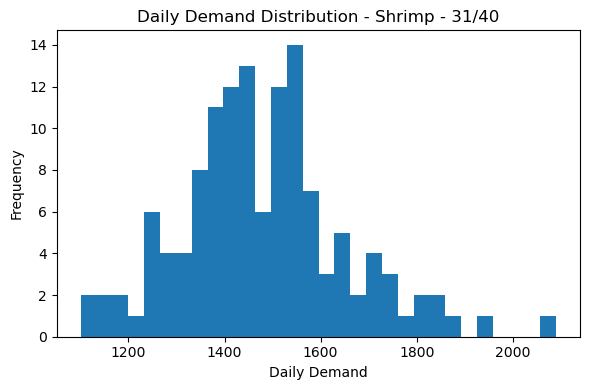

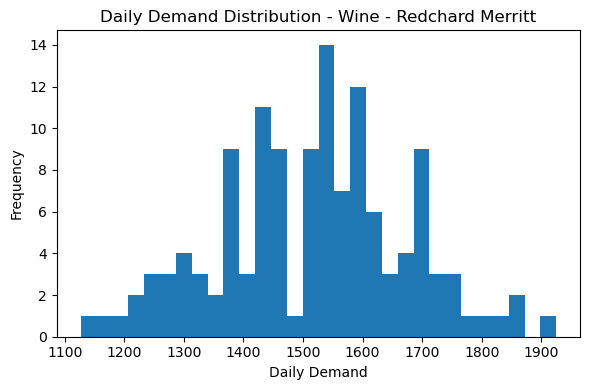

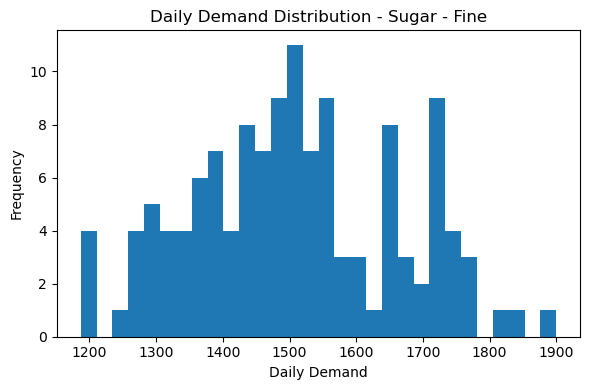

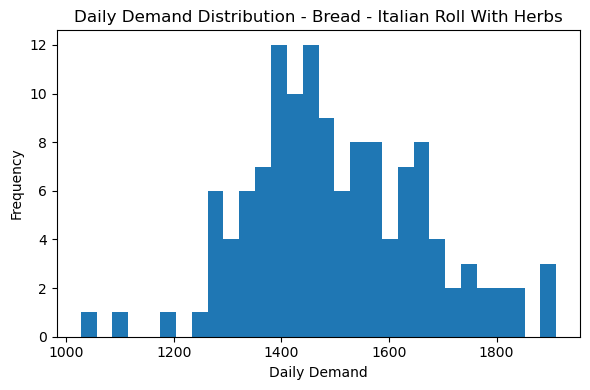

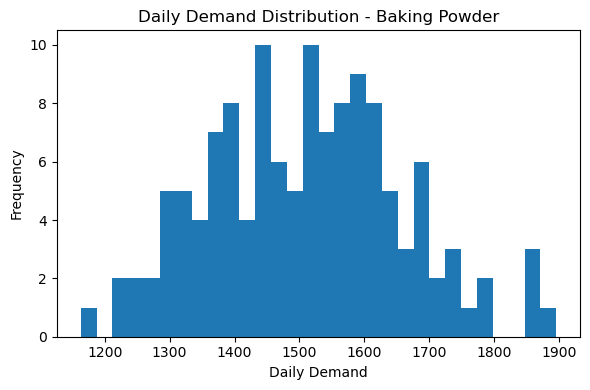

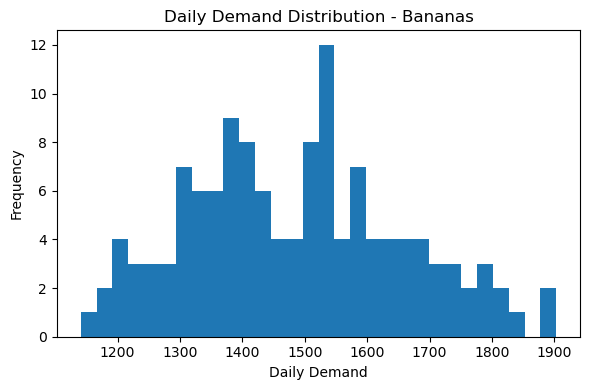

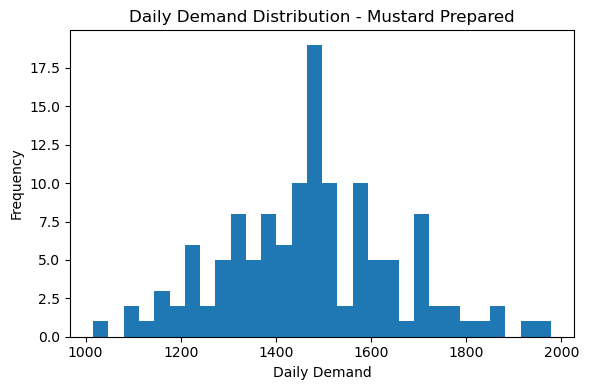

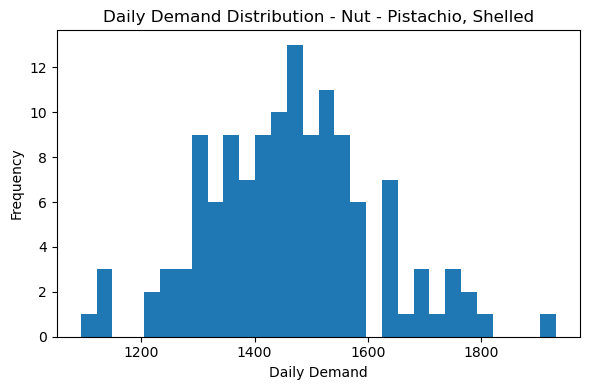

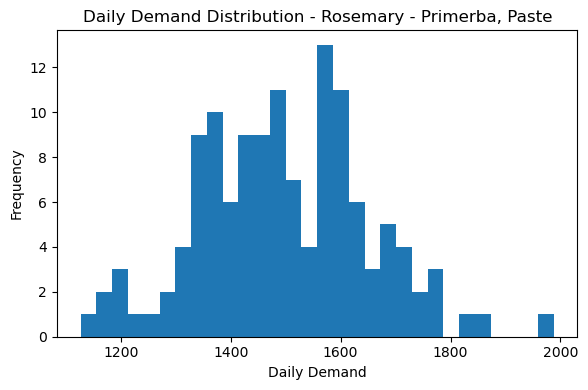

In [22]:
# Loop through each selected (category, product) pair
for category, product in selected_products.items():

     # Filter the master daily dataset to include only the selected product
    df_prod = final_master_data_daily[
        final_master_data_daily["ProductName"] == product
    ]
  # Plot a histogram of daily demand values
    # Each bar represents how frequently a certain demand range occurs
    plt.figure(figsize=(6, 4))
    plt.hist(df_prod["Daily_Demand"], bins=30)
    plt.title(f"Daily Demand Distribution - {product}")
    plt.xlabel("Daily Demand")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [23]:
#Copy dataset for Prophet modeling
prophet_master = final_master_data_daily.copy()


In [24]:
#Rename columns to Prophet-required names
prophet_master = prophet_master.rename(
    columns={
        "SalesDate": "ds",
        "Daily_Demand": "y"
    }
)


In [25]:
prophet_master.head(10)

,ProductID,ProductName,CategoryName,CategoryID,ds,y,Total_Daily_Sales,Avg_Discount
0,1,Flour - Whole Wheat,Grain,8,2018-01-01,1567,113550.85604,0.029825
1,1,Flour - Whole Wheat,Grain,8,2018-01-02,1569,112867.30708,0.031092
2,1,Flour - Whole Wheat,Grain,8,2018-01-03,1481,105994.66808,0.032500
3,1,Flour - Whole Wheat,Grain,8,2018-01-04,1458,105214.53068,0.035772
4,1,Flour - Whole Wheat,Grain,8,2018-01-05,1588,113431.97796,0.037903
5,1,Flour - Whole Wheat,Grain,8,2018-01-06,1531,111046.98648,0.028814
6,1,Flour - Whole Wheat,Grain,8,2018-01-07,1681,119375.88196,0.043307
7,1,Flour - Whole Wheat,Grain,8,2018-01-08,1329,95882.60140,0.033654
8,1,Flour - Whole Wheat,Grain,8,2018-01-09,1336,97101.10172,0.021154
9,1,Flour - Whole Wheat,Grain,8,2018-01-10,1868,135424.42276,0.021168


In [26]:
#Convert ds to datetime and sort
prophet_master["ds"] = pd.to_datetime(prophet_master["ds"])
prophet_master = prophet_master.sort_values(["ProductID", "ds"])


In [27]:
#Ensure continuous daily frequency for each product
prophet_master = (
    prophet_master
    .set_index("ds")
    .groupby("ProductID", group_keys=False)
    .apply(
        lambda x: x
        .asfreq("D")
        .fillna({
            "y": 0,
            "Avg_Discount": 0,
            "Total_Daily_Sales": 0
        })
    )
    .reset_index()
)


C:\Users\abdul\AppData\Local\Temp\ipykernel_20616\2632981824.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [28]:
#Binary variable indicating weekends
prophet_master["is_weekend"] = (
    prophet_master["ds"].dt.weekday.isin([5, 6]).astype(int)
)


In [29]:
prophet_master.columns


Index(['ds', 'ProductID', 'ProductName', 'CategoryName', 'CategoryID', 'y',
       'Total_Daily_Sales', 'Avg_Discount', 'is_weekend'],
      dtype='object')

In [30]:
# pick the Specify the product to be used for Prophet forecasting
product_name = "Cookie Chocolate Chip With"

product_df = prophet_master[
    prophet_master["ProductName"] == product_name
].copy()


In [31]:
# Split the dataset into training and testing sets
train_df = product_df.iloc[:-14]
test_df = product_df.iloc[-14:]



In [32]:
from prophet import Prophet
#Initialize Prophet with seasonality settings
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)
#Add external regressors
model.add_regressor("Avg_Discount")
model.add_regressor("is_weekend")
#Fit model on training data
model.fit(train_df[["ds", "y", "Avg_Discount", "is_weekend"]])


10:43:13 - cmdstanpy - INFO - Chain [1] start processing
10:43:13 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# Use the trained Prophet model to generate predictions
# We pass only the columns required by Prophet:
forecast = model.predict(
    test_df[["ds", "Avg_Discount", "is_weekend"]]
)




In [34]:
#Merge predictions with actual values
forecast_eval = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].merge(
    test_df[["ds", "y"]],
    on="ds",
    how="left"
)


In [35]:
# Import libraries to measure forecast accuracy

import numpy as np

# Mean Absolute Error (MAE)
# Average absolute difference between actual demand and predicted demand
mae = mean_absolute_error(forecast_eval["y"], forecast_eval["yhat"])
# Root Mean Squared Error (RMSE)
# Penalizes larger errors more heavily than MAE
rmse = np.sqrt(mean_squared_error(forecast_eval["y"], forecast_eval["yhat"]))
# Mean Absolute Percentage Error (MAPE)
# Measures forecast error as a percentage of actual demand
mape = np.mean(
    np.abs((forecast_eval["y"] - forecast_eval["yhat"]) / forecast_eval["y"])
) * 100

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


MAE  : 87.46
RMSE : 105.73
MAPE : 5.94%


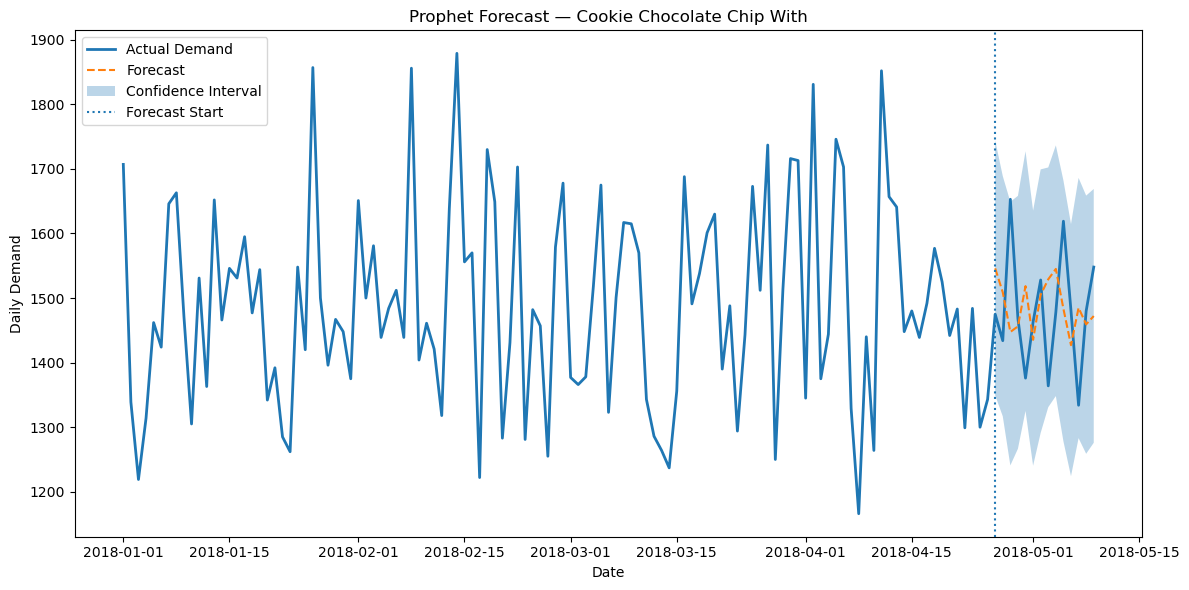

In [36]:

plt.figure(figsize=(12, 6))

# Plot the actual historical daily demand
plt.plot(
    product_df["ds"],
    product_df["y"],
    label="Actual Demand",
    linewidth=2
)
# Plot Prophet's predicted demand
plt.plot(
    forecast["ds"],
    forecast["yhat"],
    label="Forecast",
    linestyle="--"
)

# Plot the uncertainty interval (confidence interval)
# Shows the range in which true demand is likely to fall

plt.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    alpha=0.3,
    label="Confidence Interval"
)

plt.axvline(
    test_df["ds"].iloc[0],
    linestyle=":",
    label="Forecast Start"
)

plt.title("Prophet Forecast — Cookie Chocolate Chip With")
plt.xlabel("Date")
plt.ylabel("Daily Demand")
plt.legend()
plt.tight_layout()
plt.show()


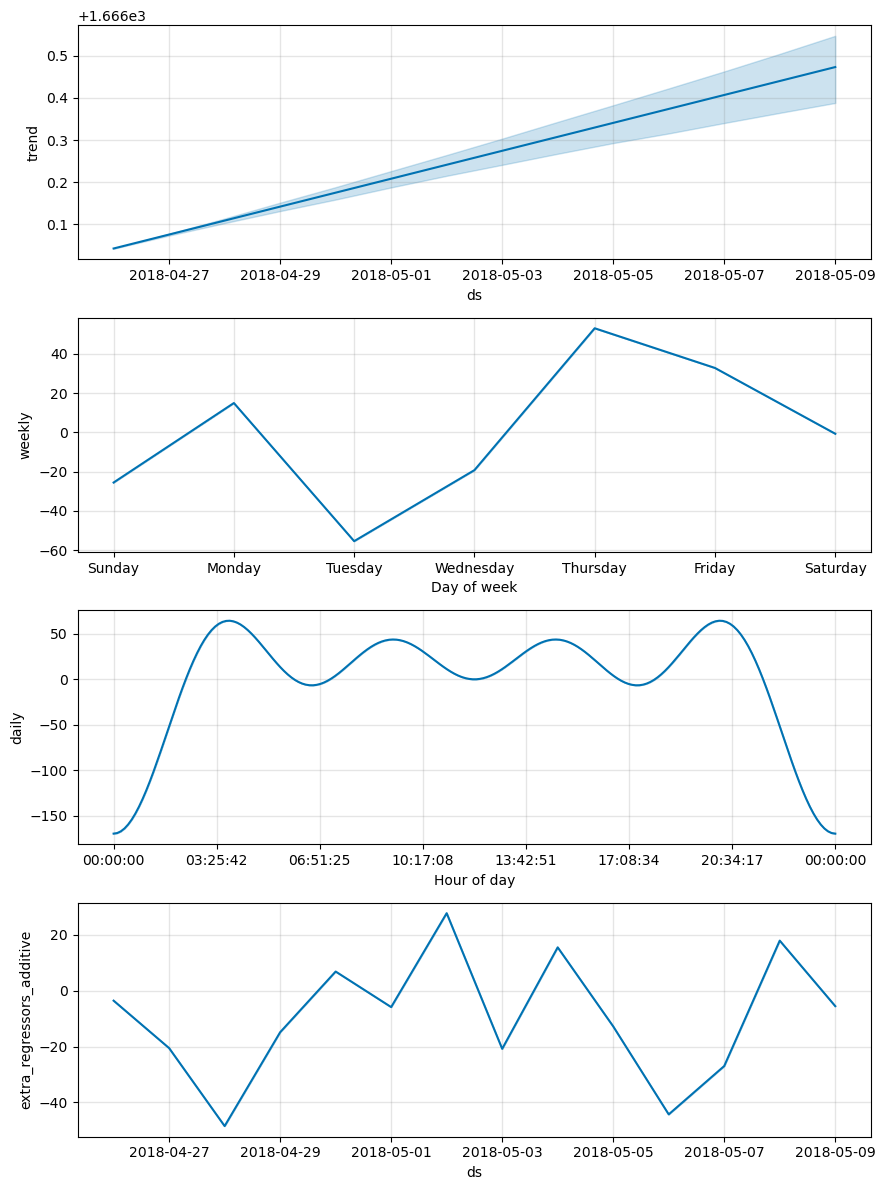

In [37]:
# Plot individual components learned by the Prophet model
model.plot_components(forecast)
plt.show()


In [38]:
# Make a copy of the original product dataframe to preserve the raw data
full_df = product_df.copy()


# Initialize the Prophet model with specific seasonality settings:
model_final = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)

model_final.add_regressor("Avg_Discount")
model_final.add_regressor("is_weekend")

model_final.fit(
    full_df[["ds", "y", "Avg_Discount", "is_weekend"]]
)


10:43:23 - cmdstanpy - INFO - Chain [1] start processing
10:43:24 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# Create a future dataframe for forecasting
future = model_final.make_future_dataframe(periods=14, freq="D")


In [40]:
# Create a binary column 'is_weekend' for the future dates:
future["is_weekend"] = (
    future["ds"].dt.weekday.isin([5, 6]).astype(int)
)
# Set 'Avg_Discount' for future dates as the average discount from historical data
future["Avg_Discount"] = full_df["Avg_Discount"].mean()



In [41]:
# Use the trained Prophet model to make predictions for all dates in the 'future' dataframe
forecast = model_final.predict(future)
# Extract only the future forecast (dates beyond the last observed date in the historical data)
future_forecast = forecast[forecast["ds"] > full_df["ds"].max()][
    ["ds", "yhat", "yhat_lower", "yhat_upper"]
]

future_forecast


,ds,yhat,yhat_lower,yhat_upper
129,2018-05-10,1530.454096,1339.046026,1712.316556
130,2018-05-11,1515.429098,1334.264491,1711.989243
131,2018-05-12,1489.550319,1301.976371,1669.175210
132,2018-05-13,1448.584095,1242.306271,1652.018459
133,2018-05-14,1489.914484,1291.513022,1684.405814
134,2018-05-15,1437.333809,1250.228212,1636.069182
135,2018-05-16,1476.175996,1284.360928,1682.829978
136,2018-05-17,1530.040191,1342.233947,1722.209952
137,2018-05-18,1515.015193,1320.395900,1689.723341
138,2018-05-19,1489.136413,1302.670494,1681.510143


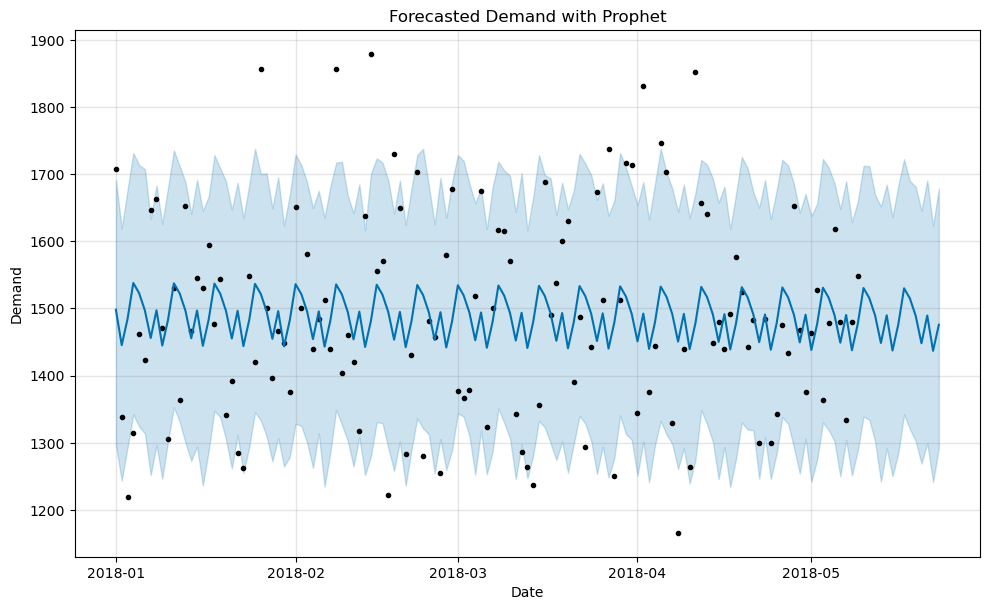

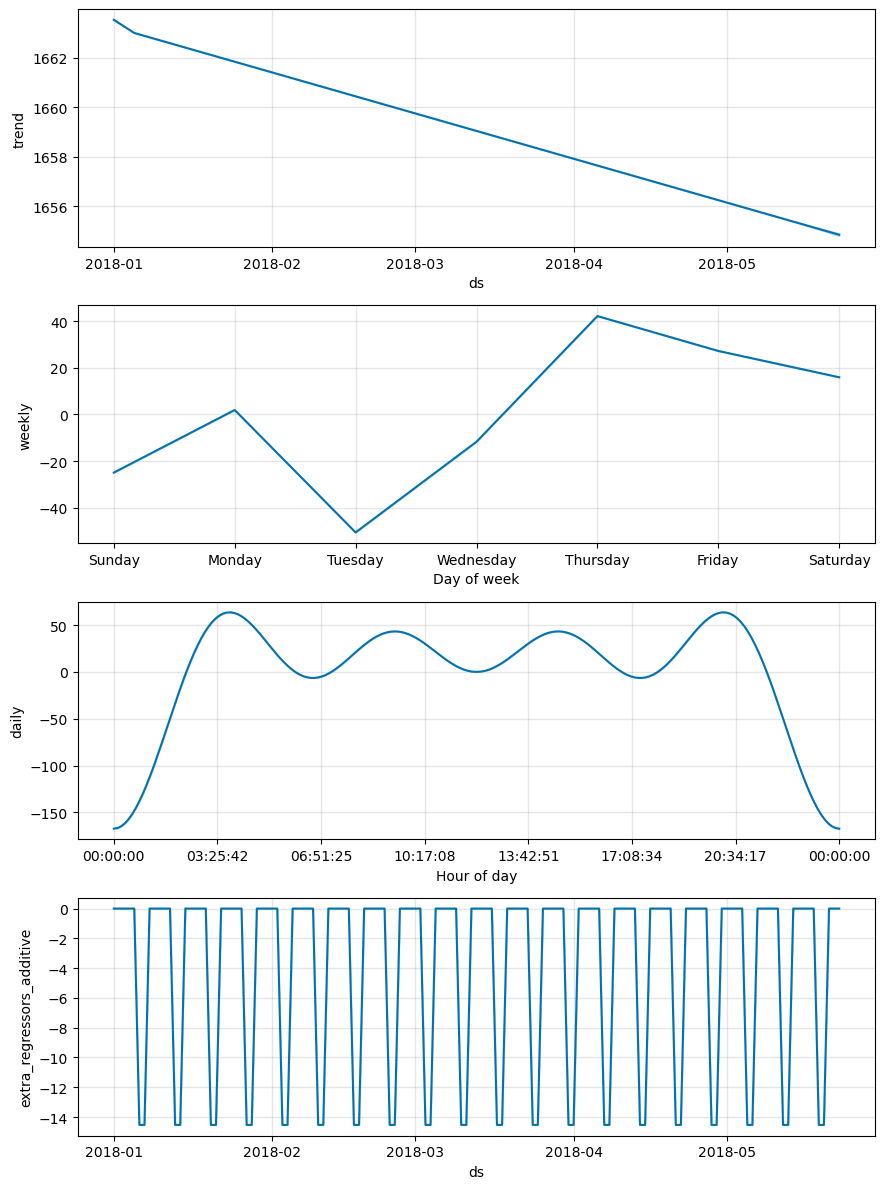

In [42]:
# Plot the forecast using Prophet's built-in plotting function
#The historical data (black points)
#The forecasted values (blue line)
#The uncertainty interval (light blue shaded area)
#forecast = model_final.predict(future)

#Plot the forecast (including trend, seasonality, and uncertainty)
model_final.plot(forecast)
plt.title("Forecasted Demand with Prophet")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.show()

#Plot the components (trend, weekly seasonality, daily seasonality)
model_final.plot_components(forecast)
plt.show()



In [43]:


#Model evaluation results(one row per product)
evaluation_results = []

#Future forecasts(many rows per product)
future_forecasts = []

In [44]:
product_list = prophet_master[["ProductID", "ProductName", "CategoryName"]].drop_duplicates()


In [45]:
print("Total products:", product_list.shape[0])

prophet_master.groupby("ProductID").size().describe()


Total products: 252


count    252.0
mean     129.0
std        0.0
min      129.0
25%      129.0
50%      129.0
75%      129.0
max      129.0
dtype: float64

In [46]:
for _, prod in product_list.iterrows():

    product_id = prod["ProductID"]
    product_name = prod["ProductName"]
    category_name = prod["CategoryName"]
   
    #Extract product data
    df = prophet_master[prophet_master["ProductID"] == product_id].copy()
    df = df.sort_values("ds")

    #Safety check: skip very short series
    if len(df) < 30:
        continue

    #Train–test split (last 14 days)
    train_df = df.iloc[:-14]
    test_df = df.iloc[-14:]

    #Train Prophet model
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False
    )

    model.add_regressor("Avg_Discount")
    model.add_regressor("is_weekend")

    try:
        model.fit(train_df[["ds", "y", "Avg_Discount", "is_weekend"]])
    except Exception as e:
        print(f" Skipped {product_name}: model fit failed")
        continue

    #Predict test period
    forecast_test = model.predict(
        test_df[["ds", "Avg_Discount", "is_weekend"]]
    )


    #Evaluation metrics
    mae = mean_absolute_error(test_df["y"], forecast_test["yhat"])
    rmse = np.sqrt(mean_squared_error(test_df["y"], forecast_test["yhat"]))
    y_true = np.array(test_df["y"], dtype=float)
    y_pred = np.array(forecast_test["yhat"], dtype=float)

    # Safety guard
    if np.any(y_true == 0):
        mape = np.nan
    else:
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


    evaluation_results.append({
        "ProductID": product_id,
        "ProductName": product_name,
        "CategoryName": category_name,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

    #Re-train on FULL data
    model_final = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False
    )

    model_final.add_regressor("Avg_Discount")
    model_final.add_regressor("is_weekend")

    model_final.fit(
        df[["ds", "y", "Avg_Discount", "is_weekend"]]
    )

    #Create future dataframe

    future = model_final.make_future_dataframe(periods=14, freq="D")

    future["is_weekend"] = (
        future["ds"].dt.weekday.isin([5, 6]).astype(int)
    )

    # Assume future discount = historical average
    future["Avg_Discount"] = df["Avg_Discount"].mean()

    #Forecast future demand
    forecast_future = model_final.predict(future)

    future_only = forecast_future[
        forecast_future["ds"] > df["ds"].max()
    ][["ds", "yhat", "yhat_lower", "yhat_upper"]]

    future_only["ProductID"] = product_id
    future_only["ProductName"] = product_name
    future_only["CategoryName"] = category_name

    future_forecasts.append(future_only)


10:43:28 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing
10:43:28 - cmdstanpy - INFO - Chain [1] start processing
10:43:28 - cmdstanpy - INFO - Chain [1] done processing
10:43:29 - cmdstanpy - INFO - Chain [1] start processing
10:43:29 - cmdstanpy - INFO - Chain [1] done processing
10:43:30 - cmdstanpy - INFO - Chain [1] start processing
10:43:30 - cmdstanpy - INFO - Chain [1] done processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] done processing
10:43:31 - cmdstanpy - INFO - Chain [1] start processing
10:43:31 - cmdstanpy - INFO - Chain [1] done processing
10:43:32 - cmdstanpy - INFO - Chain [1] start processing
10:43:32 - cmdstanpy - INFO - Chain [1] done processing
10:43:33 - cmdstanpy - INFO - Chain [1] start processing
10:43:33 - cmdstanpy - INFO - Chain [1] done processing
10:43:33 - cmdstanpy - INFO - Chain [1] start processing
10:43:34 - cmdstanpy - INFO - Chain [1]

In [47]:
evaluation_df = pd.DataFrame(evaluation_results)
forecast_df = pd.concat(future_forecasts, ignore_index=True)


In [48]:
evaluation_df.head(20)

,ProductID,ProductName,CategoryName,MAE,RMSE,MAPE
0,1,Flour - Whole Wheat,Grain,101.052007,114.948804,6.694248
1,2,Cookie Chocolate Chip With,Cereals,87.460600,105.732687,5.944562
2,6,Wine - Magnotta - Cab Sauv,Wine,154.245725,176.923875,9.901121
3,8,Halibut - Steaks,Seafood,106.871280,129.146954,7.267194
4,10,Scampi Tail,Seafood,131.014508,174.936598,8.518151
5,13,"Water, Tap",Beverages,100.380047,114.685693,6.647496
6,14,Beef - Top Sirloin,Meat,116.869134,142.948325,7.917205
7,17,"Wine - White, Mosel Gold",Wine,153.115155,178.793098,10.109432
8,18,"Lamb - Whole, Fresh",Meat,147.161938,163.618085,9.759841
9,19,Tea - Earl Grey,Beverages,114.529863,166.713503,7.422065


In [49]:
forecast_df.head(50)

,ds,yhat,yhat_lower,yhat_upper,ProductID,ProductName,CategoryName
0,2018-05-10,1424.980248,1227.286746,1610.792617,1,Flour - Whole Wheat,Grain
1,2018-05-11,1460.649636,1274.783168,1637.978580,1,Flour - Whole Wheat,Grain
2,2018-05-12,1444.951683,1264.965160,1627.335626,1,Flour - Whole Wheat,Grain
3,2018-05-13,1452.804734,1273.856193,1634.848878,1,Flour - Whole Wheat,Grain
4,2018-05-14,1440.001349,1244.549503,1620.511086,1,Flour - Whole Wheat,Grain
5,2018-05-15,1409.972604,1225.371226,1610.178334,1,Flour - Whole Wheat,Grain
6,2018-05-16,1465.040181,1295.755168,1655.775504,1,Flour - Whole Wheat,Grain
7,2018-05-17,1422.262325,1230.380792,1619.417544,1,Flour - Whole Wheat,Grain
8,2018-05-18,1457.931713,1261.750605,1649.232475,1,Flour - Whole Wheat,Grain
9,2018-05-19,1442.233760,1255.267547,1618.986053,1,Flour - Whole Wheat,Grain
